In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

In [2]:
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_prod_0_consolidated.parquet"
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_binsize_0.5_sec_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_vis_target_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_aud_target_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [ ]:
session_table.to_pandas().query('session_id == "664851_2023-11-13"')['areas_recorded'].values

In [ ]:
# results=pl.scan_parquet(results_path)

In [ ]:
# results.columns

In [5]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [6]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modal_dprime_vis_blocks',
            'cross_modal_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
                               'cross_modal_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modal_dprime_vis_blocks', 
                                                           'cross_modal_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
        pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    )
    .sort('structure', 'unit_subsample_size', descending=False)
    .collect()
)


In [7]:
new_results_session_df

structure,total_n_units,cross_modal_dprime_aud_blocks,session_id,time_aligned_to,unit_subsample_size,cross_modal_dprime_vis_blocks,n_passing_blocks,bin_center,bin_size,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
str,u32,str,str,enum,u16,str,i64,f64,f64,f64,f64,list[f64],list[i16],f64
"""ACAd""",104,"""1.8732033617740693;0.507978653…","""703880_2024-04-18""","""response_time""",20,"""-0.2695477415109305;-0.3627181…",2,0.25,0.5,0.587039,0.586167,"[0.560176, 0.574275, … 0.580614]","[-25, -24, … 7]",0.000873
"""ACAd""",142,"""2.4559009101846447;0.707844464…","""686176_2023-12-04""","""stim_start_time""",20,"""2.801652384074433;2.0039433232…",5,-0.25,0.5,0.754467,0.668372,"[0.615722, 0.625735, … 0.61993]","[-41, -40, … 44]",0.086095
"""ACAd""",223,"""0.945366508442188;0.0908991361…","""703882_2024-04-23""","""response_time""",20,"""-0.6229257232100878;1.92660927…",1,3.75,0.5,0.582167,0.582722,"[0.560167, 0.602, … 0.567778]","[-26, -25, … 3]",-0.000556
"""ACAd""",255,"""2.3232519772603974;-0.17819061…","""733891_2024-09-20""","""stim_start_time""",20,"""2.45218766527143;1.57884181457…",3,2.75,0.5,0.543632,0.543821,"[0.573684, 0.569263, … 0.520714]","[-43, -42, … 43]",-0.000189
"""ACAd""",500,"""2.7498784264405276;2.219541086…","""674562_2023-10-04""","""stim_start_time""",20,"""3.5343620836938268;3.190051031…",6,-1.25,0.5,0.722946,0.652462,"[0.545165, 0.550342, … 0.637934]","[-43, -42, … 20]",0.070484
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""root""",173,"""0.29293181590561934;2.64489216…","""662892_2023-08-23""","""response_time""",20,"""3.0833722162690016;2.791631359…",5,1.25,0.5,0.595368,0.546947,"[0.486138, 0.507488, … 0.536404]","[-19, -18, … 24]",0.048421
"""root""",173,"""0.29293181590561934;2.64489216…","""662892_2023-08-23""","""response_time""",20,"""3.0833722162690016;2.791631359…",5,0.75,0.5,0.540734,0.535069,"[0.531269, 0.548842, … 0.565212]","[-19, -18, … 24]",0.005665
"""root""",173,"""0.29293181590561934;2.64489216…","""662892_2023-08-23""","""response_time""",20,"""3.0833722162690016;2.791631359…",5,-2.25,0.5,0.514161,0.542754,"[0.54027, 0.542754, … 0.547298]","[-19, -18, … 24]",-0.028593


In [8]:
new_results_session_pd=new_results_session_df.to_pandas()

In [ ]:
new_results_session_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_binsize_0.5_sec_0_2025-05-19\decoder_accuracy_by_session_vis_target_only.parquet", index=False)

In [ ]:
new_results_session_pd.query('session_id=="742903_2024-10-22" and structure=="MOs" and \
                             time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

In [ ]:
# new_results_session_pd['session_id'].unique()

Text(0.5, 1.0, '742903_2024-10-22; MOs; stim_start_time; 20 units')

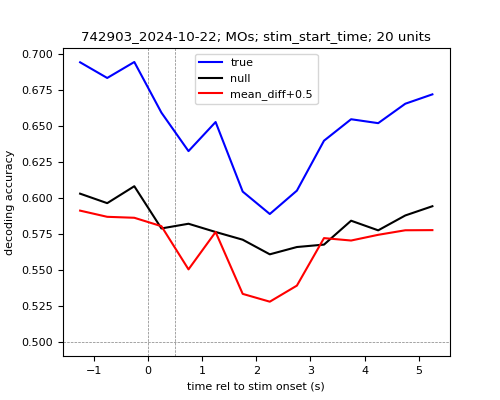

In [9]:
sel_session="742903_2024-10-22"
sel_structure="MOs"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')
example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                     time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label='true', color='blue')
ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['median_null'], label='null', color='black')

ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_diff']+0.5, label='mean_diff+0.5', color='red')

# ax.set_ylim(0.5,1)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

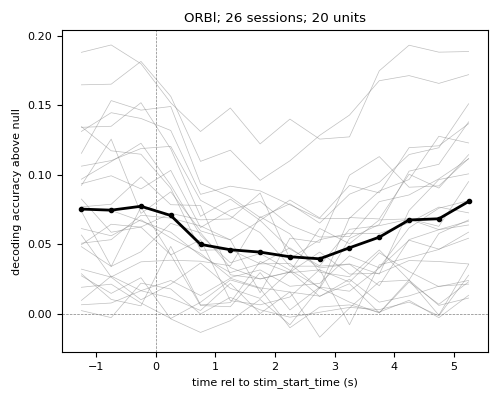

In [10]:
#example area average from good sessions

sel_structure="ORBl"
time_aligned_to="stim_start_time"
min_n_passing_blocks=4

structure_accuracy=np.vstack(new_results_session_pd.query(
    'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
    ).sort_values(
        ['session_id','bin_center']
        ).groupby(['session_id'])['mean_diff'].apply(np.array).values)

bins=np.vstack(new_results_session_pd.query(
    'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
    ).sort_values(
        ['session_id','bin_center']
        ).groupby(['session_id'])['bin_center'].apply(np.array).values)[0]

n_sessions=len(structure_accuracy)

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins,structure_accuracy.T, color='grey', alpha=0.5, linewidth=0.5)
ax.plot(bins,np.nanmean(structure_accuracy,axis=0), color='black', marker='.', linewidth=2)

ax.set_title(f"{sel_structure}; {n_sessions} sessions; {sel_unit_subsample_size} units")
ax.set_xlabel('time rel to '+time_aligned_to+' (s)')
ax.set_ylabel('decoding accuracy above null')

fig.tight_layout()

In [11]:
#average over areas from good sessions

time_aligned_to="response_time"
min_n_passing_blocks=4

mean_timemod_accuracy_by_structure={
    'structure':[],
    'mean_diff':[],
    'mean_diff_std':[],
    'mean_diff_sem':[],
    'n_sessions':[],
}

for sel_structure in new_results_session_pd.query('n_passing_blocks>=4')['structure'].unique():
    structure_accuracy=np.vstack(new_results_session_pd.query(
        'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
        ).sort_values(
            ['session_id','bin_center']
            ).groupby(['session_id'])['mean_diff'].apply(np.array).values)

    bins=np.vstack(new_results_session_pd.query(
        'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
        ).sort_values(
            ['session_id','bin_center']
            ).groupby(['session_id'])['bin_center'].apply(np.array).values)[0]
    
    n_sessions=len(structure_accuracy)

    mean_timemod_accuracy_by_structure['structure'].append(sel_structure)
    mean_timemod_accuracy_by_structure['mean_diff'].append(np.nanmean(structure_accuracy,axis=0))
    mean_timemod_accuracy_by_structure['mean_diff_std'].append(np.nanstd(structure_accuracy,axis=0))
    mean_timemod_accuracy_by_structure['mean_diff_sem'].append(stats.sem(structure_accuracy, axis=0, nan_policy='omit'))
    mean_timemod_accuracy_by_structure['n_sessions'].append(n_sessions)

mean_timemod_accuracy_by_structure_df=pd.DataFrame(mean_timemod_accuracy_by_structure)

c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encounte

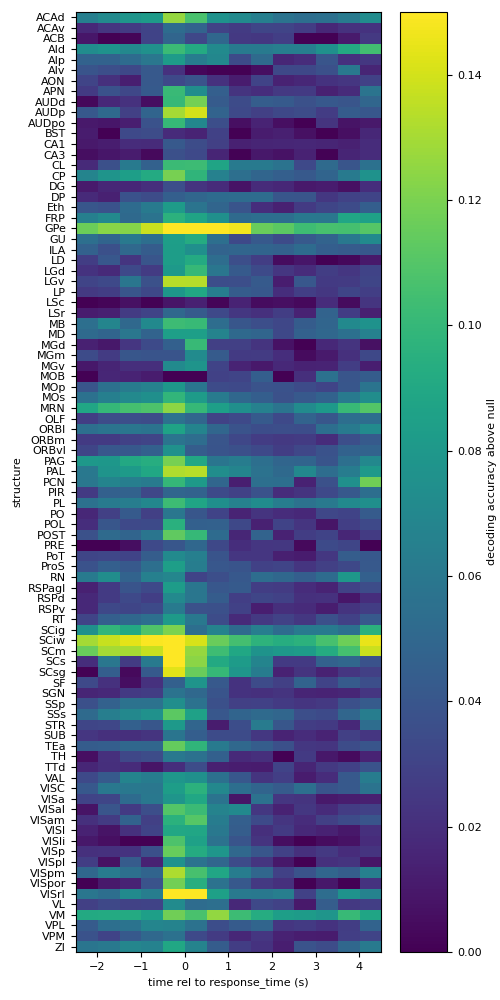

In [12]:
structure_matrix=np.vstack(mean_timemod_accuracy_by_structure_df.query('n_sessions>=3')['mean_diff'].values)
structure_labels=mean_timemod_accuracy_by_structure_df.query('n_sessions>=3')['structure'].values

fig,ax=plt.subplots(1,1,figsize=(5,10))
im=ax.imshow(structure_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=0.15, extent=[bins[0]-0.25, bins[-1]+0.25, len(structure_labels), 0])
ax.set_yticks(np.arange(len(structure_labels))+0.5, structure_labels, ha='right')
# ax.set_xticks(np.arange(len(bins)))
# ax.set_xticklabels(bins)
ax.set_xlabel('time rel to '+time_aligned_to+' (s)')
ax.set_ylabel('structure')

# ax.set_title(f"mean decoding accuracy above null; {sel_unit_subsample_size} units; {min_n_passing_blocks} blocks")

fig.colorbar(im, ax=ax, label='decoding accuracy above null')
fig.tight_layout()

In [ ]:
bins

In [13]:

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_context', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_context', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [14]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [ ]:
predict_proba_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_binsize_0.5_sec_0_2025-05-19\predict_proba_by_session.parquet", index=False)

In [15]:
predict_proba_pd['structure'].unique()

array(['ACAv', 'CA1', 'DG', 'LSr', 'MOs', 'TEa', 'VISli', 'VISp', 'VISal',
       'AUDd', 'ORBl', 'ORBvl', 'POST', 'SSp', 'SSs', 'AUDp', 'AUDpo',
       'CP', 'LD', 'LGd', 'LP', 'PO', 'STR', 'VISpm', 'VPM', 'CA3',
       'ProS', 'MOp', 'PoT', 'SGN', 'VISam', 'VISl', 'MRN', 'RSPagl',
       'MB', 'PL', 'VISa', 'ACB', 'AId', 'PAL', 'SUB', 'VL', 'AIv', 'PIR',
       'LSc', 'POL', 'ILA', 'ORBm', 'APN', 'RSPd', 'SCm', 'VISrl', 'Eth',
       'MGd', 'MGv', 'MGm', 'RSPv', 'SAG', 'VISpor', 'SCiw', 'RT', 'VPL',
       'ACAd', 'MS', 'PAG', 'SCig', 'VAL', 'ICd', 'OT', 'root', 'FRP',
       'SCs', 'MOB', 'IG', 'OLF', 'MPT', 'BST', 'LGv', 'CL', 'TH', 'AMv',
       'PR', 'SF', 'VM', 'EPd', 'GU', 'AON', 'AV', 'DP', 'BLAp', 'CA2',
       'ENTl', 'GPe', 'LSv', 'MD', 'LH', 'MH', 'SCsg', 'SH', 'CLA', 'PP',
       'SCop', 'RN', 'SMT', 'PCN', 'V3', 'ZI', 'ECT', 'ECT6a', 'TRS',
       'CS', 'PSTN', 'PF', 'ECT2/3', 'PERI', 'TTd', 'SNr', 'GPi', 'DTN',
       'ENTm', 'PRE', 'VISpl', 'AUDv', 'AIp', 'VISC', 'PAR'

In [16]:
sel_session="664851_2023-11-13"
sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='response_time'

###hack used until we add trial_index to the results
if sel_time_aligned_to=='response_time':
    temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                            time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                            ).sort_values('bin_center').iloc[0]
    
    trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
    is_vis_context=temp_trial_info['is_vis_context'][temp_trial_info['is_response']]
    stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
    is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)
    trial_index_list=[]
    is_vis_context_list=[]
    stim_name_list=[]
    is_response_list=[]
    for rr in range(len(example_area_results)):
        trial_index_list.append(trial_index)
        is_vis_context_list.append(is_vis_context)
        stim_name_list.append(stim_name)
        is_response_list.append(is_response)

    example_area_results['trial_index']=trial_index_list
    example_area_results['is_vis_context']=is_vis_context_list
    example_area_results['stim_name']=stim_name_list
    example_area_results['is_response']=is_response_list

else:
    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)

np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0]

array([ 25,  55,  92, 124, 152], dtype=int64)

In [ ]:
# example_area_results.loc[rr,'trial_index']
# trial_index
# example_area_results.iloc[0]

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.plot(example_area_results['is_vis_context'].iloc[0],'k.')
ax.vlines(x=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0],ymin=-.1,ymax=1.1, color='red', linestyle='--', linewidth=0.5)

In [ ]:
sel_trial=92
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(example_area_results['bin_center'],np.vstack(example_area_results['predict_proba'].values)[:,sel_trial], 'k.-')
ax.set_ylim(0,1)

ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units; \n \
             trial {example_area_results['trial_index'].iloc[0][sel_trial]}; {example_area_results['stim_name'].iloc[0][sel_trial]}; is_vis_context={example_area_results['is_vis_context'].iloc[0][sel_trial]}")

In [ ]:
# is_vis_context

In [ ]:
predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

fig,ax=plt.subplots(1,1,figsize=(6,15))
im=ax.imshow(predict_proba_stack, aspect='auto', interpolation='none', extent=[-0.4, 2.0, predict_proba_stack.shape[0],0], cmap='bwr', vmin=0, vmax=1)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('predict_proba')

#make tickmarks on right side for false alarms
is_vis_context=example_area_results['is_vis_context'].values[0]
stim_name=example_area_results['stim_name'].values[0]
is_response=example_area_results['is_response'].values[0]

is_false_alarm=(
    is_vis_context & (stim_name == 'sound1') & (is_response == True) |
    ~is_vis_context & (stim_name == 'vis1') & (is_response == True)
)

is_hit=(
    is_vis_context & (stim_name == 'vis1') & (is_response == True) |
    ~is_vis_context & (stim_name == 'sound1') & (is_response == True)
)

is_correct_reject=(
    is_vis_context & (stim_name == 'sound1') & (is_response == False) |
    ~is_vis_context & (stim_name == 'vis1') & (is_response == False)
)

is_miss=(
    is_vis_context & (stim_name == 'vis1') & (is_response == False) |
    ~is_vis_context & (stim_name == 'sound1') & (is_response == False)
)


ax2=ax.twinx()
# ax2.set_ylim(0, predict_proba_stack.shape[0])
ax2.set_ylim(predict_proba_stack.shape[0],0)

ax2.plot([2.1]*len(np.where(is_hit)[0]), np.where(is_hit)[0]+0.5, 'g_', label='hit', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_correct_reject)[0]), np.where(is_correct_reject)[0]+0.5, 'b_', label='correct reject', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_false_alarm)[0]), np.where(is_false_alarm)[0]+0.5, 'r_', label='false alarm', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_miss)[0]), np.where(is_miss)[0]+0.5, 'k_', label='miss', clip_on=False, markersize=12)

# ax2.set_yticks(np.where(is_false_alarm)[0])
ax2.set_yticklabels([])

#plot context switch lines
context_switches=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0]
for rr in range(len(context_switches)):
    ax2.axhline(y=context_switches[rr], color='k', linestyle='-', linewidth=2.0)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('trials')
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [ ]:
# aggregate predict proba in a smart way over trials & structures


# switches (contingent, non-contingent) + pre,post block dprime + trials_since_switch


# rewards (lick & get reward) + block dprime + is_instruction_trial


# reward prediction errors (lick & get no reward, no lick & get reward?) + block dprime + is_instruction_trial


# average non target, non response



In [ ]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """
    
    if sel_time_aligned_to=='response_time':
        temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').iloc[0]
        
        trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
        is_vis_context=temp_trial_info['is_vis_context'][temp_trial_info['is_response']]
        stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
        is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
        trial_index_list=[]
        is_vis_context_list=[]
        stim_name_list=[]
        is_response_list=[]
        for rr in range(len(example_area_results)):
            trial_index_list.append(trial_index)
            is_vis_context_list.append(is_vis_context)
            stim_name_list.append(stim_name)
            is_response_list.append(is_response)

        example_area_results['trial_index']=trial_index_list
        example_area_results['is_vis_context']=is_vis_context_list
        example_area_results['stim_name']=stim_name_list
        example_area_results['is_response']=is_response_list

    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
        
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [ ]:
# all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/performance.parquet').collect().to_pandas()



In [ ]:
# all_performance.query(f'session_id=="{sel_session}"').columns

In [ ]:
#get predict_proba relative to switches, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

get_trials_rel_to_switch=[-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet').collect().to_pandas()

context_switch_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'trial_rel_to_switch':[],
    'switch_index_in_session':[],
    'is_response':[],
    'is_vis_context':[],
    'is_contingent_switch':[],
    'stim_name':[],
    'dprime_before_switch':[],
    'dprime_after_switch':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_trials=all_trials.query(f'session_id=="{sel_session}"')
        
        #find the context switches
        context_switch_trial_index=np.where(example_area_results.iloc[0]['is_context_switch'])[0]

        #loop through context switches
        for ii,tt in enumerate(context_switch_trial_index):
            # print(f"Context switch {ii} of {len(context_switch_trial_index)}")
            # print(f"Trial {tt} of {len(example_area_results['is_context_switch'].iloc[0])}")
            dprime_before_switch=session_performance['cross_modal_dprime'].iloc[ii]
            dprime_after_switch=session_performance['cross_modal_dprime'].iloc[ii+1]

            #get whether the switch was contingent
            if sel_time_aligned_to=='response_time':
                print('WARNING: contingent/noncontingent not validated for response time aligned results')
                is_contingent_switch=np.nan
            else:
                is_contingent_switch=example_area_results['is_response'].iloc[0][tt]

            #get the is_vis_context
            is_vis_context=example_area_results['is_vis_context'].iloc[0][tt]

            for t_diff in get_trials_rel_to_switch:
                if tt+t_diff >= predict_proba_stack.shape[0]:
                    print(f"session {sel_session} structure {sel_structure} ERROR:")
                    print("trial index out of bounds of predict_proba stack;")
                    print(f"tt={tt}; t_diff={t_diff}; tt+t_diff={tt+t_diff}; predict_proba_stack.shape[0]={predict_proba_stack.shape[0]}")
                    print("skipping trial")
                    continue
                    
                #get trial from predict_proba_stack
                predict_proba_values=predict_proba_stack[tt+t_diff,:]

                #get the bin center of the trial
                bin_centers=example_area_results['bin_center'].values

                #get the is_response
                is_response=example_area_results['is_response'].iloc[0][tt+t_diff]

                #get the stim_name
                stim_name=example_area_results['stim_name'].iloc[0][tt+t_diff]

                #get the trial index
                trial_index=example_area_results['trial_index'].iloc[0][tt+t_diff]

                #append to the context switch table
                context_switch_table['session_id'].append(sel_session)
                context_switch_table['structure'].append(sel_structure)
                context_switch_table['predict_proba'].append(predict_proba_values)
                context_switch_table['bin_centers'].append(bin_centers)
                context_switch_table['unit_subsample_size'].append(sel_unit_subsample_size)
                context_switch_table['time_aligned_to'].append(sel_time_aligned_to)
                context_switch_table['trial_index'].append(trial_index)
                context_switch_table['trial_rel_to_switch'].append(t_diff)
                context_switch_table['switch_index_in_session'].append(ii)
                context_switch_table['is_response'].append(is_response)
                context_switch_table['is_vis_context'].append(is_vis_context)
                context_switch_table['is_contingent_switch'].append(is_contingent_switch)
                context_switch_table['stim_name'].append(stim_name)
                context_switch_table['dprime_before_switch'].append(dprime_before_switch)
                context_switch_table['dprime_after_switch'].append(dprime_after_switch)

context_switch_table_df=pd.DataFrame(context_switch_table)
# context_switch_table_df


In [ ]:
# predict_proba_stack.shape
# response_trial_index
# sel_session
rr

In [ ]:
predict_proba_pd.query('session_id==@sel_session')['structure'].unique()

In [ ]:
context_switch_table_df

In [ ]:
# context_switch_table_df.query('is_vis_context==True and is_response==True and trial_rel_to_switch==0')

In [ ]:
sel_structure='MOs'
sel_trial_rel_to_switch=0
sel_is_response=True

aud_to_vis_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_context==True and is_response==@sel_is_response and trial_rel_to_switch==@sel_trial_rel_to_switch')
vis_to_aud_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_context==False and is_response==@sel_is_response and trial_rel_to_switch==@sel_trial_rel_to_switch')

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(aud_to_vis_switches['bin_centers'].iloc[0], 
        np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
        label=f'A->V ({len(aud_to_vis_switches)})', color='blue', marker='.')
ax.fill_between(
    aud_to_vis_switches['bin_centers'].iloc[0], 
    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
    -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
    +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
    color='blue', alpha=0.2)
ax.plot(vis_to_aud_switches['bin_centers'].iloc[0], 
        np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
        label=f'V->A ({len(vis_to_aud_switches)})', color='green', marker='.')
ax.fill_between(
    vis_to_aud_switches['bin_centers'].iloc[0], 
    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
    -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
    +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
    color='green', alpha=0.2)

# ax.set_ylim(0.2,0.8)
ax.set_xlabel('time rel to event (s)')
ax.set_ylabel('predict_proba')
ax.set_title(f"{sel_structure}; aligned to {sel_time_aligned_to}; {sel_unit_subsample_size} \n trial_rel_to_switch={sel_trial_rel_to_switch}; is_response={sel_is_response}")
ax.legend()
fig.tight_layout()

In [ ]:
#plot across instruction trials
# sel_structure='ACAd'
# sel_is_contingent_switch=True
min_dprime=0.5

# savefigs=True
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-05-19-decoder_timepoints_0.5_bins\response_time"

for sel_structure in context_switch_table_df['structure'].unique():
    # sel_structure='ACAd'
    for sel_is_contingent_switch in [True,False]:

        fig,ax=plt.subplots(1,6,figsize=(16,4),sharex=True,sharey=True)

        for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):

            aud_to_vis_switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_context==True and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            vis_to_aud_switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_context==False and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            
            ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
            ax[xx].axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
            if len(vis_to_aud_switches) > 0:
                ax[xx].plot(vis_to_aud_switches['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
                        label=f'V->A ({len(vis_to_aud_switches)})', color='blue', marker='.')
                ax[xx].fill_between(
                    vis_to_aud_switches['bin_centers'].iloc[0], 
                    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
                    -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
                    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
                    +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
                    color='blue', alpha=0.2)
            
            if len(aud_to_vis_switches) > 0:
                ax[xx].plot(aud_to_vis_switches['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                        label=f'A->V ({len(aud_to_vis_switches)})', color='green', marker='.')
                ax[xx].fill_between(
                    aud_to_vis_switches['bin_centers'].iloc[0], 
                    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
                    -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
                    +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                    color='green', alpha=0.2)

            # ax.set_ylim(0.2,0.8)
            ax[xx].set_xlabel('time rel to event (s)')
            if xx==0:
                ax[xx].set_ylabel('predict_proba')
            ax[xx].legend()
            ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
        fig.suptitle(f"{sel_structure}; is_contingent={sel_is_contingent_switch}; aligned to {sel_time_aligned_to}; {sel_unit_subsample_size} units; min dprime={min_dprime}")
        fig.tight_layout()

        if sel_is_contingent_switch:
            sel_is_contingent_str='contingent'
        else:
            sel_is_contingent_str='noncontingent'

        fig.savefig(os.path.join(savepath,f"{sel_structure.replace('/','-')}_{sel_is_contingent_str}.png"), dpi=300)
        plt.close(fig)

        
    # break


In [ ]:
#heatmap - align to noncontingent 1st trial of switch

In [ ]:
# aud_to_vis_switches
vis_to_aud_switches

In [ ]:
#### response time adjustments

#get predict_proba relative to switches, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet').collect().to_pandas()

context_switch_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'trial_rel_to_switch':[],
    'switch_index_in_session':[],
    'is_response':[],
    'is_vis_context':[],
    'is_contingent_switch':[],
    'stim_name':[],
    'dprime_before_switch':[],
    'dprime_after_switch':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_trials=all_trials.query(f'session_id=="{sel_session}"')

        #choose values based on their actual, not implied, trial index
        context_switch_trial_index=session_trials.query('is_context_switch')['trial_index'].values
        trial_index=example_area_results['trial_index'].iloc[0]

        #loop through context switches
        for ii,tt in enumerate(context_switch_trial_index):
            # print(f"Context switch {ii} of {len(context_switch_trial_index)}")
            # print(f"Trial {tt} of {len(example_area_results['is_context_switch'].iloc[0])}")
            dprime_before_switch=session_performance['cross_modal_dprime'].iloc[ii]
            dprime_after_switch=session_performance['cross_modal_dprime'].iloc[ii+1]

            is_contingent_switch=session_trials['is_response'].iloc[tt]

            #get the is_vis_context
            is_vis_context=session_trials['is_vis_context'].iloc[tt]

            for t_diff in get_trials_rel_to_switch:

                adj_tt=np.where(trial_index==tt+t_diff)[0]
                if len(adj_tt) == 0:
                    # print(f"session {sel_session} structure {sel_structure} ERROR:")
                    # print("trial index not found in predict_proba stack;")
                    # print("skipping trial")
                    continue
                else:
                    adj_tt=adj_tt[0]

                if tt+t_diff!=trial_index[adj_tt]:
                    print('ERROR: trial index not matching!!')
                    break
                
                if adj_tt >= predict_proba_stack.shape[0]:
                    print(f"session {sel_session} structure {sel_structure} ERROR:")
                    print("trial index out of bounds of predict_proba stack;")
                    print("skipping trial")
                    continue
                    
                #get trial from predict_proba_stack
                predict_proba_values=predict_proba_stack[adj_tt,:]

                #get the bin center of the trial
                bin_centers=example_area_results['bin_center'].values

                #get the is_response
                is_response=example_area_results['is_response'].iloc[0][adj_tt]

                #get the stim_name
                stim_name=example_area_results['stim_name'].iloc[0][adj_tt]

                #append to the context switch table
                context_switch_table['session_id'].append(sel_session)
                context_switch_table['structure'].append(sel_structure)
                context_switch_table['predict_proba'].append(predict_proba_values)
                context_switch_table['bin_centers'].append(bin_centers)
                context_switch_table['unit_subsample_size'].append(sel_unit_subsample_size)
                context_switch_table['time_aligned_to'].append(sel_time_aligned_to)
                context_switch_table['trial_index'].append(trial_index[adj_tt])
                context_switch_table['trial_rel_to_switch'].append(t_diff)
                context_switch_table['switch_index_in_session'].append(ii)
                context_switch_table['is_response'].append(is_response)
                context_switch_table['is_vis_context'].append(is_vis_context)
                context_switch_table['is_contingent_switch'].append(is_contingent_switch)
                context_switch_table['stim_name'].append(stim_name)
                context_switch_table['dprime_before_switch'].append(dprime_before_switch)
                context_switch_table['dprime_after_switch'].append(dprime_after_switch)

context_switch_table_df=pd.DataFrame(context_switch_table)
# context_switch_table_df


In [ ]:
min_dprime=0.5

structure_list=context_switch_table_df['structure'].unique()

structure_average_predict_proba={
    'structure':[],
    'predict_proba':[],
    'trial_rel_to_switch':[],
    'is_contingent_switch':[],
    'is_vis_context':[],
    'n_switches':[],
}

for sel_structure in structure_list:
    for sel_is_vis_context in [True,False]:
        for sel_is_contingent_switch in [True,False]:
            for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):
                switches=context_switch_table_df.query(
                    'structure==@sel_structure and is_vis_context==@sel_is_vis_context and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                    is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
                
                if len(switches) > 0:
                    #get the predict proba for the structure
                    structure_predict_proba=np.vstack(switches['predict_proba'].values)

                    #average across trials
                    structure_average_predict_proba['structure'].append(sel_structure)
                    structure_average_predict_proba['trial_rel_to_switch'].append(sel_trial_rel_to_switch)
                    structure_average_predict_proba['is_contingent_switch'].append(sel_is_contingent_switch)
                    structure_average_predict_proba['is_vis_context'].append(sel_is_vis_context)

                    #stack the predict proba
                    structure_predict_proba=np.vstack(structure_predict_proba)

                    #average across trials
                    structure_average_predict_proba['predict_proba'].append(np.nanmean(structure_predict_proba, axis=0))
                    structure_average_predict_proba['n_switches'].append(len(switches))
                
                
structure_average_predict_proba_df=pd.DataFrame(structure_average_predict_proba)

In [ ]:
# context_switch_table_df.query(
#     'structure==@sel_structure and is_vis_context==@is_vis_context and trial_rel_to_switch==0 and \
#     is_contingent_switch==True and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
# context_switch_table_df.query('is_contingent_switch==True')

In [ ]:
structure_average_predict_proba_df['structure'].unique()

In [ ]:
is_vis_context=True
is_contingent_switch=False
min_n_switches=12

structure_result_list=structure_average_predict_proba_df.query('n_switches>=@min_n_switches').sort_values(by='structure')['structure'].unique()

fig,ax=plt.subplots(1,6,figsize=(12,8),sharex=True,sharey=True)
for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):
    
    sel_switches=structure_average_predict_proba_df.query(
        'trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_vis_context==@is_vis_context and \
        is_contingent_switch==@is_contingent_switch')# and \
        # n_switches>=@min_n_switches').sort_values(by='structure')
    
    ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
    if len(sel_switches) == 0:
        continue

    heatmap_array=np.full((len(structure_result_list), len(sel_switches['predict_proba'].iloc[0])), np.nan)

    for ss,structure_str in enumerate(structure_result_list):
        if structure_str in sel_switches['structure'].values:
            heatmap_array[ss,:]=sel_switches.query('structure==@structure_str')['predict_proba'].values[0]
        else:
            heatmap_array[ss,:]=np.nan
            
    im=ax[xx].imshow(heatmap_array, aspect='auto', interpolation='none', cmap='bwr', vmin=0.2, vmax=0.8, extent=[-1.5, 5.5, heatmap_array.shape[0]-0.5,-0.5])
    ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax[xx].set_xlabel('time rel to event (s)')
    ax[xx].set_yticks(np.arange(len(structure_result_list)))
    ax[xx].set_yticklabels(structure_result_list, ha='right')

fig.suptitle(f"is_vis_context={is_vis_context}; is_contingent_switch={is_contingent_switch}; time_aligned_to={sel_time_aligned_to}")
fig.tight_layout()

In [ ]:
sel_switches

In [ ]:
#get predict_proba for different trial types, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='response_time'

# get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet').collect().to_pandas()

trial_type_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'is_response':[],
    'is_vis_context':[],
    'stim_name':[],
    'n_trials':[],
    'session_dprime':[],
    'n_passing_vis_blocks':[],
    'n_passing_aud_blocks':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    
    session_performance=all_performance.query(f'session_id=="{sel_session}"')
    session_dprime=session_performance['cross_modal_dprime'].mean()
    n_passing_vis_blocks=session_performance.query('rewarded_modality=="vis" and cross_modal_dprime>1').shape[0]
    n_passing_aud_blocks=session_performance.query('rewarded_modality=="aud" and cross_modal_dprime>1').shape[0]
    session_trials=all_trials.query(f'session_id=="{sel_session}"')

    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        #these are the indices of trials with data (i.e. for response aligned trials)
        trial_index=example_area_results['trial_index'].iloc[0]

        if trial_index.shape[0]!=predict_proba_stack.shape[0]:
            print('warning! trial_index does not match predict_proba_stack, just taking the first X trials')
            trial_index=trial_index[:predict_proba_stack.shape[0]]

        #loop through type of trials?
        for is_vis_context in [True,False]:

            for stim_name in session_trials['stim_name'].unique():

                for is_response in [True,False]:

                    #get the trial indices for this trial type
                    trial_type_indices=session_trials.query(
                        'is_reward_scheduled==False and is_vis_context==@is_vis_context and \
                        stim_name==@stim_name and is_response==@is_response'
                        )['trial_index'].values

                    #get the subset of these trial indices available in the data
                    available_trial_type_indices=np.where(np.isin(trial_index, trial_type_indices))[0]

                    #get the number of trials
                    n_trials=len(available_trial_type_indices)

                    if n_trials == 0:
                        predict_proba_values=np.nan*np.ones(predict_proba_stack.shape[1])
                    else:
                        #get the average preidict_proba for these trials
                        predict_proba_values=np.nanmean(predict_proba_stack[available_trial_type_indices,:], axis=0)

                    trial_type_table['session_id'].append(sel_session)
                    trial_type_table['structure'].append(sel_structure)
                    trial_type_table['predict_proba'].append(predict_proba_values)
                    trial_type_table['bin_centers'].append(example_area_results['bin_center'].values)
                    trial_type_table['unit_subsample_size'].append(sel_unit_subsample_size)
                    trial_type_table['time_aligned_to'].append(sel_time_aligned_to)
                    trial_type_table['trial_index'].append(available_trial_type_indices)
                    trial_type_table['is_response'].append(is_response)
                    trial_type_table['is_vis_context'].append(is_vis_context)
                    trial_type_table['stim_name'].append(stim_name)
                    trial_type_table['n_trials'].append(n_trials)
                    trial_type_table['session_dprime'].append(session_dprime)
                    trial_type_table['n_passing_vis_blocks'].append(n_passing_vis_blocks)
                    trial_type_table['n_passing_aud_blocks'].append(n_passing_aud_blocks)


trial_type_table_df=pd.DataFrame(trial_type_table)



In [ ]:
# available_trial_type_indices
trial_index.shape
# predict_proba_stack.shape
# np.isin(trial_type_indices, trial_index)
# trial_index
# example_area_results['stim_name'].iloc[0][available_trial_type_indices]

In [ ]:
# trial_type_table_df

In [ ]:
# sel_structure='ACAd'

min_n_trials=3

min_n_good_blocks=2

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-05-19-decoder_timepoints_0.5_bins\trial_types-response_time"

for sel_structure in trial_type_table_df['structure'].unique():

    fig,ax=plt.subplots(2,5,figsize=(14,6),sharex=True,sharey=True)

    for xx,sel_is_vis_context in enumerate([True,False]):

        for st, stim_name in enumerate(['vis1','vis2','sound1','sound2','catch']):

            for is_response in [True,False]:

                #get the trial type data
                trial_type_data=trial_type_table_df.query(
                    'structure==@sel_structure and is_vis_context==@sel_is_vis_context and \
                    stim_name==@stim_name and is_response==@is_response and n_trials>=@min_n_trials and \
                    n_passing_vis_blocks>=@min_n_good_blocks and n_passing_aud_blocks>=@min_n_good_blocks')

                if is_response:
                    plot_color='green'
                else:
                    plot_color='black'

                if len(trial_type_data) > 0:
                    n_trials=trial_type_data['predict_proba'].values.shape[0]
                    ax[xx,st].axvline(0,linestyle='--',color='k',linewidth=0.5)
                    ax[xx,st].axhline(0.5,linestyle='--',color='k',linewidth=0.5)
                    ax[xx,st].plot(trial_type_data['bin_centers'].iloc[0], 
                            np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                            label=f'is_response={str(is_response)} ({str(n_trials)})', color=plot_color, marker='.')
                    ax[xx,st].fill_between(
                        trial_type_data['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0)
                        -stats.sem(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                        np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0)
                        +stats.sem(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                        color=plot_color, alpha=0.2)

            # ax.set_ylim(0.2,0.8)
            ax[xx,st].set_xlabel('time rel to event (s)')
            if st==0:
                ax[xx,st].set_ylabel('predict_proba')
            ax[xx,st].legend()
            if sel_is_vis_context:
                ax[xx,st].set_title(f"{stim_name}; vis context")
            else:
                ax[xx,st].set_title(f"{stim_name}; aud context")

    fig.suptitle(f'{sel_structure}; aligned to {sel_time_aligned_to}')
    fig.tight_layout()

    sel_structure=sel_structure.replace('/','-')
    
    fig.savefig(os.path.join(savepath,f'{sel_structure}_{sel_time_aligned_to}'))
    plt.close(fig)


In [ ]:
f'{sel_structure}_{sel_time_aligned_to}'

In [ ]:
# predict_proba_pd

In [ ]:
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.265/consolidated/trials.parquet').collect().to_pandas()

In [ ]:
all_trials.columns

In [ ]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [ ]:
# dr_session_list

In [ ]:
# all_trials['stim_start_time'].iloc[1:].values-all_trials['stim_stop_time'].iloc[:-1].values

all_itis=[]

for session_id in all_trials['session_id'].unique():
    if session_id not in dr_session_list:
        continue
    session_itis=all_trials.query('session_id==@session_id')['stim_start_time'].values[1:]-all_trials.query('session_id==@session_id')['stim_start_time'].values[:-1]
    all_itis.append(session_itis)

all_itis_array=np.hstack(all_itis)

In [ ]:
xbins=np.arange(0, 16, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_itis_array, bins=xbins, color='grey')

ax.set_title('time between stimulus start and next stimulus start')

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
np.percentile(all_itis_array, 80)

In [ ]:
select_ranges=[
    [5.5,6],
    [6,6.5],
    [6.5,7],
    [7,7.5],
    [7.5,8],
    [8,8.5],
    [8.5,9],
    [9,10],
    [10,15]
]

xbins=np.arange(0, 15, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))

for rr in select_ranges:
    # print(f"range {rr[0]}-{rr[1]}")
    # print(np.mean((all_itis_array>rr[0]) & (all_itis_array<rr[1]))*100)

    range_itis=all_itis_array[(all_itis_array>=rr[0])&(all_itis_array<rr[1])]

    percent_of_trials=len(range_itis)/len(all_itis_array)*100

    ax.hist(range_itis, bins=xbins, label=f"{rr[0]}-{rr[1]}: {percent_of_trials:.1f}%")

ax.legend()

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
select_ranges=[
    # [5.5,6],
    # [6,6.5],
    # [6.5,7],
    # [7,7.5],
    # [7.5,8],
    # [8,8.5],
    # [8.5,9],
    # [9,10],
    # [10,15]
    [5.5,6.5],
    [6.5,7.5],
    [7.5,8.5],
    [8.5,9.5],
    [9.5,16]
]

xbins=np.arange(0, 15, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))

for rr in select_ranges:
    # print(f"range {rr[0]}-{rr[1]}")
    # print(np.mean((all_itis_array>rr[0]) & (all_itis_array<rr[1]))*100)

    range_itis=all_itis_array[(all_itis_array>=rr[0])]

    percent_of_trials=len(range_itis)/len(all_itis_array)*100

    ax.hist(range_itis, bins=xbins, label=f">={rr[0]}: {percent_of_trials:.1f}%",alpha=0.5)

ax.legend()

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
len(np.arange(-1.5,5.5,0.5))

In [ ]:
all_reaction_times=all_trials.query('is_response and session_id in @dr_session_list')['response_time'].values-all_trials.query('is_response and session_id in @dr_session_list')['stim_start_time'].values
all_reaction_times
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times, bins=np.arange(0, 1.01, 0.01), color='grey')
ax.axvline(x=np.nanmedian(all_reaction_times), color='red', linestyle='--', linewidth=0.5, label=f"median={np.nanmedian(all_reaction_times):.2f}")

ax.set_xlabel('reaction time (s)')
ax.set_ylabel('count')
ax.legend()
fig.tight_layout()

In [ ]:
#differentiate hits and false alarms
all_reaction_times_hits=(
    all_trials.query('is_hit and session_id in @dr_session_list')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list')['stim_start_time'].values
)
all_reaction_times_fa=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list')['stim_start_time'].values
)

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times_hits, bins=np.arange(0, 1.01, 0.01), color='green', alpha=0.5, label='hits', cumulative=True, density=True, histtype="step",)
ax.hist(all_reaction_times_fa, bins=np.arange(0, 1.01, 0.01), color='red', alpha=0.5, label='false alarms', cumulative=True, density=True, histtype="step",)


In [ ]:
#differentiate hits and false alarms
all_reaction_times_hits_vis=(
    all_trials.query('is_hit and session_id in @dr_session_list and is_vis_target')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list and is_vis_target')['stim_start_time'].values
)
all_reaction_times_fa_vis=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_vis_target')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_vis_target')['stim_start_time'].values
)
all_reaction_times_hits_aud=(
    all_trials.query('is_hit and session_id in @dr_session_list and is_aud_target')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list and is_aud_target')['stim_start_time'].values
)
all_reaction_times_fa_aud=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_aud_target')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_aud_target')['stim_start_time'].values
)


fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times_hits_vis, bins=np.arange(0, 1.01, 0.01), color='tab:green', alpha=0.5, 
        label='vis hits', cumulative=True, density=True, histtype="step",linewidth=1.5)
ax.hist(all_reaction_times_fa_vis, bins=np.arange(0, 1.01, 0.01), color='tab:red', alpha=0.5, 
        label='vis fas', cumulative=True, density=True, histtype="step",linewidth=1.5)
ax.hist(all_reaction_times_hits_aud, bins=np.arange(0, 1.01, 0.01), color='tab:green', alpha=0.5, 
        label='aud hits', cumulative=True, density=True, histtype="step",linewidth=1.5,linestyle='--')
ax.hist(all_reaction_times_fa_aud, bins=np.arange(0, 1.01, 0.01), color='tab:red', alpha=0.5, 
        label='aud fas', cumulative=True, density=True, histtype="step",linewidth=1.5,linestyle='--')

ax.legend()
ax.set_xlabel('reaction time (s)')
ax.set_ylabel('cumulative density')
fig.tight_layout()
